# 1. Review Dataset and Build Image Loading Function

### 1.1 Import TF and Deps

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import os

### 1.2 Limit GPU Memory Growth

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.3 Load Image into TF Data Pipeline

#### Define Primary Dataset Source
Specify the dataset source ('webcam', 'seccam', or 'seccam2') that will be used throughout the entire image preprocessing and augmentation pipeline

In [68]:
dataset = 'seccam' # or seccam, seccam_2
subsets = ['train','test','val']

# Define image sizes for each dataset source
IMAGE_SIZES = {
    "webcam": (480, 640),
    "seccam": (800, 1280),
    "seccam_2": (800, 1280)
}

Check if the dataset is available and load images for processing

In [69]:
images = tf.data.Dataset.list_files(f'data/datasets/{dataset}/train/images/*.jpg')
images.as_numpy_iterator().next()

b'data\\datasets\\seccam\\train\\images\\476c87ed-83ac-11ee-a88d-9cfeff47d2fa.jpg'

In [70]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [71]:
images = images.map(load_image)
images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 1.4 View Raw Images with Matplotlib

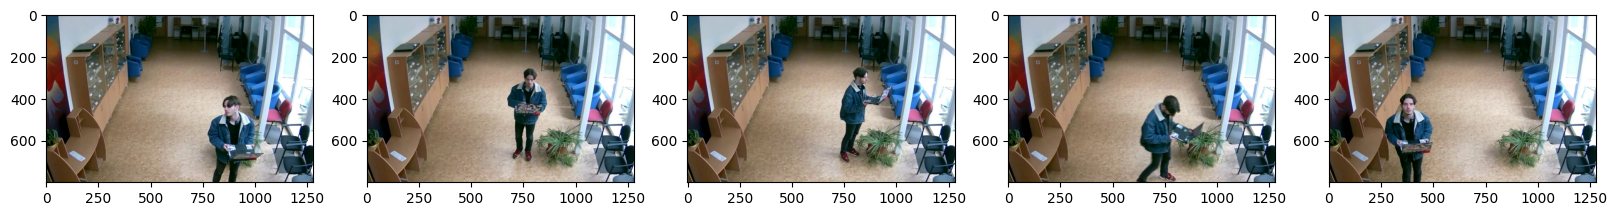

In [76]:
image_generator = images.batch(5).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 2. Partition Unaugmented Data

### 2.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
30*.7 # 21 to train

21.0

In [ ]:
30*.15 # 5 and 4 to test and val

4.5

### 2.2 Move the Matching Labels

In [ ]:
for subset in subsets:    
    for file in os.listdir(os.path.join('data', 'datasets', dataset, subset, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'datasets', dataset, 'labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data', 'datasets', dataset, subset, 'labels', filename)
            os.replace(existing_filepath, new_filepath)      

# 3. Apply Image Augmentation on Images and Labels using Albumentations

### 3.1 Setup Albumentations Transform Pipeline

In [45]:
import albumentations as alb

In [77]:
augmentor = alb.Compose([alb.RandomCrop(width=IMAGE_SIZES[dataset][1], height=IMAGE_SIZES[dataset][0]), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels'], 
                                                  min_area=0.001,  # Minimum area as a fraction of the image
                                                  min_visibility=0.1))

### 3.2 Load a Test Image and Annotation with OpenCV and JSON

In [78]:
import cv2
import os
import json
import numpy as np

# Assuming 'dataset' is defined earlier in the code
image_dir = os.path.join('data/datasets', dataset, 'train', 'images')
label_dir = os.path.join('data/datasets', dataset, 'train', 'labels')

# Get first image file
image_file = os.listdir(image_dir)[0]
# Get corresponding label file
label_file = image_file.split('.')[0] + '.json'

img = cv2.imread(os.path.join(image_dir, image_file))
with open(os.path.join(label_dir, label_file), 'r') as f:
    label = json.load(f)

shapes = label['shapes']  # Extract shapes list
shapes

[{'label': '1',
  'points': [[772.7433628318583, 419.46902654867256],
   [836.4601769911504, 368.14159292035396]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

### 3.3 Extract Coordinates and Rescale to Match Image Resolution

In [79]:

coords_list = []
labels_list = []

for shape in shapes:
    coords = [0,0,0,0]
    # First get x and y coordinates from both points
    x1 = shape['points'][0][0]
    y1 = shape['points'][0][1]
    x2 = shape['points'][1][0]
    y2 = shape['points'][1][1]

    # Now set coordinates ensuring min and max are correct
    coords[0] = min(x1, x2)  # x_min
    coords[1] = min(y1, y2)  # y_min
    coords[2] = max(x1, x2)  # x_max
    coords[3] = max(y1, y2)  # y_max
    coords = list(np.divide(coords, [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]))
    coords_list.append(coords)
    labels_list.append(shape['label'])

for coords, label in zip(coords_list, labels_list):
    print(f"Label: {label}, Coordinates: {coords}")

Label: 1, Coordinates: [np.float64(0.6037057522123893), np.float64(0.46017699115044247), np.float64(0.6534845132743363), np.float64(0.5243362831858407)]


### 3.4 Apply Augmentations and View Results

In [80]:
augmented = augmentor(image=img, bboxes=coords_list, class_labels=labels_list)

for bbox, label in zip(augmented['bboxes'], augmented['class_labels']):
    print(f"Augmented Label: {label}, Augmented BBox: {bbox}")

Augmented Label: 1, Augmented BBox: [0.3465154767036438, 0.4756637215614319, 0.3962942361831665, 0.5398229956626892]


In [81]:
if len(augmented['bboxes']) != 0:
    augmented['bboxes'][0][2:]


In [82]:
augmented['bboxes']

[[0.3465154767036438,
  0.4756637215614319,
  0.3962942361831665,
  0.5398229956626892]]

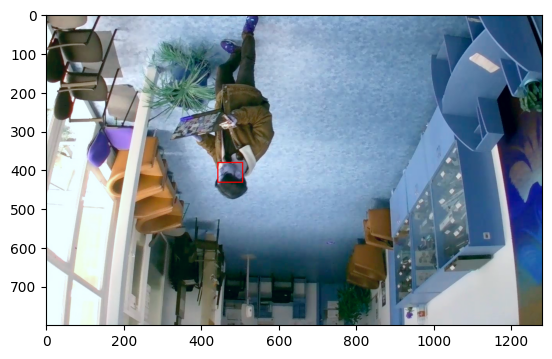

In [83]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [IMAGE_SIZES[dataset][1], IMAGE_SIZES[dataset][0]]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [IMAGE_SIZES[dataset][1], IMAGE_SIZES[dataset][0]]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 4. Build and Run Augmentation Pipeline

In [84]:
for subset in subsets: 
    for image in os.listdir(os.path.join('data/datasets', dataset, subset, 'images')):
        img = cv2.imread(os.path.join('data/datasets', dataset, subset, 'images', image))

        coords_list = []
        labels_list = []
        label_path = os.path.join('data/datasets', dataset, subset, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            for shape in label['shapes']:
                # Ensure coords are in correct order (x_min, y_min, x_max, y_max)
                x_min = min(shape['points'][0][0], shape['points'][1][0])
                x_max = max(shape['points'][0][0], shape['points'][1][0])
                y_min = min(shape['points'][0][1], shape['points'][1][1])
                y_max = max(shape['points'][0][1], shape['points'][1][1])

                coords = [x_min, y_min, x_max, y_max]
                coords = list(np.divide(coords, [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]))
                coords_list.append(coords)
                labels_list.append(shape['label'])

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=coords_list, class_labels=labels_list)
                
                # Create the folder if it doesn't exist
                folder_path = os.path.join('data', 'datasets', 'augmented', dataset, subset, 'images')
                os.makedirs(folder_path, exist_ok=True)
                augmented_image_name = f'{image.split(".")[0]}.{x}.jpg'
                cv2.imwrite(os.path.join(folder_path, augmented_image_name), augmented['image'])

                annotation = {}
                annotation['image'] = augmented_image_name
                annotation['shapes'] = []

                if os.path.exists(label_path):
                    for bbox, label in zip(augmented['bboxes'], augmented['class_labels']):
                        annotation['shapes'].append({
                            'label': label,
                            'points': [
                                [bbox[0] * img.shape[1], bbox[1] * img.shape[0]],
                                [bbox[2] * img.shape[1], bbox[3] * img.shape[0]]
                            ]
                        })

                folder_path = os.path.join('data', 'datasets', 'augmented', dataset, subset, 'labels')
                os.makedirs(folder_path, exist_ok=True)
                with open(os.path.join(folder_path, f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)